# EDA
Since the inception of 3on3 overtime, are more games (that require extra time) going to a shootout?

In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install scipy

In [2]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

##### read in data for 2020-21 regular season


In [3]:
# year = '2020'
years = ['2015','2016','2017','2018','2019','2020']
games = {}
for year in years:
    path = os.getcwd()
    path = os.path.abspath(os.path.join(path, os.pardir, 'data/' + year + '_regSeasonPlays.json'))
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2015_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2016_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2017_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2018_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2019_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2020_regSeasonPlays.json


##### get a list of the winning team for each game ending in overtime

In [4]:
game_results = []

record = {}
record['game_id'] = ''
record['home_team'] = ''
record['away_team'] = ''
record['home_goals'] = ''
record['away_goals'] = ''
record['winning_team'] = ''
record['losing_team'] = ''
record['last_period'] = ''

for year in games:
    for game_id, game in games[year].items():
        ## game_id and home/away team names ##
        record['game_id'] = game_id
        record['home_team'] = game['home_team']
        record['away_team'] = game['away_team']

        ## get goals for each team ##
        for event in game['events']:
            if event['result']['eventTypeId'] == 'GAME_END':
                record['home_goals'] = event['about']['goals']['home']
                record['away_goals'] = event['about']['goals']['away']
                record['last_period'] = event['about']['periodType']

        ## calculate which team won/lost the game based on number of goals ##
        if record['home_goals'] > record['away_goals']:
            record['winning_team'] = record['home_team']
            record['losing_team'] = record['away_team']
        else:
            record['winning_team'] = record['away_team']
            record['losing_team'] = record['home_team']

        game_results.append(record.copy())


##### convert to pandas dataframe

In [5]:
# game results data
df_winloss = pd.DataFrame.from_dict(game_results)
display(df_winloss.head())
display(df_winloss['last_period'].value_counts())

,game_id,home_team,away_team,home_goals,away_goals,winning_team,losing_team,last_period
0,2015020001,Toronto Maple Leafs,Montréal Canadiens,1,3,Montréal Canadiens,Toronto Maple Leafs,REGULAR
1,2015020002,Chicago Blackhawks,New York Rangers,2,3,New York Rangers,Chicago Blackhawks,REGULAR
2,2015020003,Calgary Flames,Vancouver Canucks,1,5,Vancouver Canucks,Calgary Flames,REGULAR
3,2015020004,Los Angeles Kings,San Jose Sharks,1,5,San Jose Sharks,Los Angeles Kings,REGULAR
4,2015020005,Boston Bruins,Winnipeg Jets,2,6,Winnipeg Jets,Boston Bruins,REGULAR


REGULAR     5563
OVERTIME    1028
SHOOTOUT     548
Name: last_period, dtype: int64

##### Verify that we correctly assigned labels by checking the total number of games per season
Also, save overtime and shootout totals for each year

In [6]:
year_results = {}

def sum_array(a):
    total = 0
    for num in a:
        total += num
    return total

print('...verifying total games per season in correct')
for year in games:
    year_results[year] = {}
    print(year + '-' + str(int(year)+1) + ' szn')
    year_val_counts = df_winloss[df_winloss['game_id'].str.startswith(year)]['last_period'].value_counts()
    print('total games: ' + str(sum_array(year_val_counts)))
    display(year_val_counts)
    
    year_results[year]['reg_end'] = year_val_counts[0]
    year_results[year]['ot_end'] = year_val_counts[1]
    year_results[year]['so_end'] = year_val_counts[2]
    year_results[year]['total_games'] = sum_array(year_val_counts)
    year_results[year]['total_extra_time_games'] = year_results[year]['ot_end'] + year_results[year]['so_end']
    
    

...verifying total games per season in correct
2015-2016 szn
total games: 1229


REGULAR     954
OVERTIME    168
SHOOTOUT    107
Name: last_period, dtype: int64

2016-2017 szn
total games: 1229


REGULAR     940
OVERTIME    190
SHOOTOUT     99
Name: last_period, dtype: int64

2017-2018 szn
total games: 1271


REGULAR     976
OVERTIME    192
SHOOTOUT    103
Name: last_period, dtype: int64

2018-2019 szn
total games: 1271


REGULAR     999
OVERTIME    184
SHOOTOUT     88
Name: last_period, dtype: int64

2019-2020 szn
total games: 1271


REGULAR     1021
OVERTIME     164
SHOOTOUT      86
Name: last_period, dtype: int64

2020-2021 szn
total games: 868


REGULAR     673
OVERTIME    130
SHOOTOUT     65
Name: last_period, dtype: int64

In [15]:
df_year = pd.DataFrame.from_dict(year_results, orient='index')
df_year

,reg_end,ot_end,so_end,total_games,total_extra_time_games
2015,954,168,107,1229,275
2016,940,190,99,1229,289
2017,976,192,103,1271,295
2018,999,184,88,1271,272
2019,1021,164,86,1271,250
2020,673,130,65,868,195


##### extract analytics
* Percentage of games requiring extra time
* Of games that require extra time, percentage that end in overtime

In [18]:
df_year['extra_time_pct'] = df_year['total_extra_time_games'] / df_year['total_games']
df_year['ot_end_over_total_extra_time_games'] = df_year['ot_end'] / (df_year['ot_end'] + df_year['so_end'])
df_year

,reg_end,ot_end,so_end,total_games,total_extra_time_games,extra_time_pct,ot_end_over_total_extra_time_games
2015,954,168,107,1229,275,0.223759,0.610909
2016,940,190,99,1229,289,0.235151,0.657439
2017,976,192,103,1271,295,0.232101,0.650847
2018,999,184,88,1271,272,0.214005,0.676471
2019,1021,164,86,1271,250,0.196696,0.656000
2020,673,130,65,868,195,0.224654,0.666667


##### create bar chart to show trends across seasons

In [19]:
years_adj = []
for year in years:
    years_adj.append(year + '-' + str(int(year)+1))

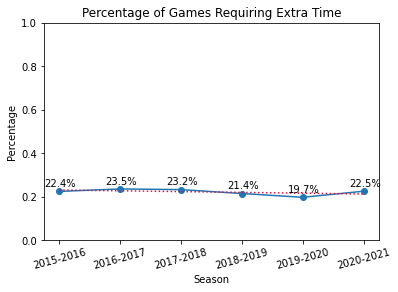

In [44]:
# create figure
fig1, ax1 = plt.subplots()

# plot data
plt.plot(years_adj, df_year['extra_time_pct'], marker='o')

# add title and axis names
plt.title('Percentage of Games Requiring Extra Time')
plt.xlabel('Season')
plt.ylabel('Percentage')

# add labels to each point
for x, y in zip(years_adj, df_year['extra_time_pct']):
    label = str(round(y*100,1))+'%'
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(1,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# adjust ticks rotation
plt.xticks(rotation=15)

# adjust y limits
plt.ylim(0,1)

# add trendline
x = list(range(0,len(years_adj)))
z = np.polyfit(x, df_year['extra_time_pct'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),linestyle=':', color='crimson')

plt.show()

# save figure to storage
fname = 'images/period_trend_ot_needed.png'
fig1.savefig(fname, bbox_inches="tight")

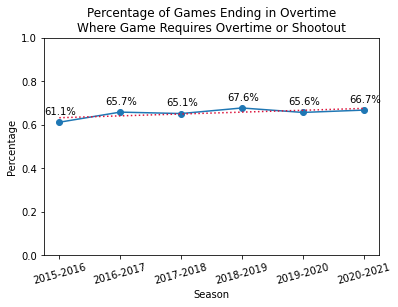

In [43]:
# create figure
fig1, ax1 = plt.subplots()

# plot data
plt.plot(years_adj, df_year['ot_end_over_total_extra_time_games'], marker='o')

# add title and axis names
plt.title('Percentage of Games Ending in Overtime\nWhere Game Requires Overtime or Shootout')
plt.xlabel('Season')
plt.ylabel('Percentage')

# add labels to each point
for x, y in zip(years_adj, df_year['ot_end_over_total_extra_time_games']):
    label = str(round(y*100,1))+'%'
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(1,8), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# adjust ticks rotation
plt.xticks(rotation=15)

# adjust y limits
plt.ylim(0,1)

# add trendline
x = list(range(0,len(years_adj)))
z = np.polyfit(x, df_year['ot_end_over_total_extra_time_games'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),linestyle=':', color='crimson')

plt.show()

# save figure to storage
fname = 'images/period_trend_ot_so_ratio.png'
fig1.savefig(fname, bbox_inches="tight")